### Load libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import zeros as sci_zeros
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from scipy import zeros as sci_zeros
from scipy.spatial.distance import euclidean

## Hierarchical clustering of the scraped Indeed.ca data

### Read the scraped Indeed.ca data

In [41]:
# set file path
ds_skills_indeed_path = 'data_science_skills.csv'

# read the .csv file
df = pd.read_csv(ds_skills_indeed_path)

# select only the skill columns
df = df.iloc[:, 6:]

df.head()

,Big Data,C/C++,Cloud,Data Mining/Analytics,DevOps,Excel,Java/Scala,MATLAB,Machine Learning,Math,...,SAS,SPSS,SQL/databases,Stata,Visualisation,communication,consulting,leadership,problem solving,project_management
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,1,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,1,0,0,0,1


### Get a list with skill names from DF columns

In [42]:
# get the list of skill names
skills_list = df.columns.values
skills_list

array(['Big Data', 'C/C++', 'Cloud', 'Data Mining/Analytics', 'DevOps',
       'Excel', 'Java/Scala', 'MATLAB', 'Machine Learning', 'Math', 'NLP',
       'Python', 'R', 'REST', 'RapidMiner', 'Ruby', 'SAS', 'SPSS',
       'SQL/databases', 'Stata', 'Visualisation', 'communication',
       'consulting', 'leadership', 'problem solving',
       'project_management'], dtype=object)

### Workflow sample -- number of job posts that mention both 'Big data' and 'DevOps'

In [29]:
mask1 = df['Big Data'] == 1
mask2 = df['DevOps'] == 1
len(df[mask1 & mask2])

24

### Generate of matrix of skill co-occurances

Record number of posts where both skills get mentioned for each pair of skills

In [17]:
# empty matrix is fill
num_skills = len(df.columns)
D = sci_zeros([num_skills, num_skills])

# Find all element wise temp differences
for i in range(num_skills):
    for j in range(num_skills):
        mask1 = df.iloc[:, i] == 1
        mask2 = df.iloc[:, j] == 1
        D[i,j] = len(df[mask1 & mask2])

* Recorded matrix of counts per skill pair. 

* Diagonal is skill "paired" with itself, simply represents total number of job posts where that individual skill is mentioned.

In [20]:
D

array([[224.,  49.,  99., 125.,  24.,  59., 121.,   8., 224.,  67.,  28.,
        182., 118.,  12.,   2.,   9.,  30.,   4., 224.,   1.,  13., 120.,
         24.,  32.,  17.,  19.],
       [ 49., 127.,  42.,  44.,  19.,  36.,  78.,  13., 127.,  25.,  16.,
        111.,  56.,   6.,   2.,   3.,   5.,   1., 127.,   0.,   2.,  83.,
          5.,  24.,  14.,   8.],
       [ 99.,  42., 179.,  82.,  28.,  48., 107.,   9., 179.,  33.,  21.,
        141.,  80.,  26.,   2.,  10.,  19.,   2., 179.,   1.,   9., 102.,
         14.,  24.,  22.,  24.],
       [125.,  44.,  82., 318.,  24., 116., 103.,  13., 318.,  72.,  24.,
        180., 148.,  14.,   5.,   2.,  41.,   8., 318.,   1.,  15., 211.,
         39.,  70.,  45.,  27.],
       [ 24.,  19.,  28.,  24.,  61.,  11.,  38.,   2.,  61.,   9.,   5.,
         43.,  19.,  12.,   0.,   5.,   6.,   0.,  61.,   0.,   2.,  33.,
          3.,   9.,   5.,   5.],
       [ 59.,  36.,  48., 116.,  11., 383.,  45.,  11., 383.,  44.,   9.,
        114., 144.,  

### Normalize the generated matrix of skill co-occurances

In [22]:
D_norm = normalize(D)
D_norm

array([[0.43317649, 0.09475736, 0.19144854, 0.24172795, 0.04641177,
        0.11409559, 0.23399266, 0.01547059, 0.43317649, 0.12956618,
        0.05414706, 0.3519559 , 0.22819119, 0.02320588, 0.00386765,
        0.01740441, 0.05801471, 0.00773529, 0.43317649, 0.00193382,
        0.02513971, 0.23205884, 0.04641177, 0.06188236, 0.032875  ,
        0.03674265],
       [0.16654244, 0.4316508 , 0.14275066, 0.14954831, 0.06457768,
        0.12235771, 0.26510837, 0.04418473, 0.4316508 , 0.08497063,
        0.0543812 , 0.3772696 , 0.19033421, 0.02039295, 0.00679765,
        0.01019648, 0.01699413, 0.00339883, 0.4316508 , 0.        ,
        0.00679765, 0.28210249, 0.01699413, 0.08157181, 0.04758355,
        0.0271906 ],
       [0.23989587, 0.10177401, 0.43375112, 0.19870163, 0.06784934,
        0.11631315, 0.25928139, 0.02180872, 0.43375112, 0.07996529,
        0.050887  , 0.34166987, 0.19385525, 0.06300296, 0.00484638,
        0.02423191, 0.04604062, 0.00484638, 0.43375112, 0.00242319,
      

In [23]:
Y = sch.linkage(D, method='centroid')

In [24]:
Y

array([[8.00000000e+00, 1.80000000e+01, 0.00000000e+00, 2.00000000e+00],
       [1.40000000e+01, 1.90000000e+01, 1.39283883e+01, 2.00000000e+00],
       [1.70000000e+01, 2.70000000e+01, 2.31408729e+01, 3.00000000e+00],
       [1.50000000e+01, 2.80000000e+01, 2.64259973e+01, 4.00000000e+00],
       [2.00000000e+01, 2.90000000e+01, 3.66444061e+01, 5.00000000e+00],
       [7.00000000e+00, 3.00000000e+01, 5.23870213e+01, 6.00000000e+00],
       [4.00000000e+00, 1.30000000e+01, 7.14352854e+01, 2.00000000e+00],
       [1.00000000e+01, 3.20000000e+01, 7.31966529e+01, 3.00000000e+00],
       [3.10000000e+01, 3.30000000e+01, 9.10143456e+01, 9.00000000e+00],
       [1.60000000e+01, 2.50000000e+01, 1.18793939e+02, 2.00000000e+00],
       [2.40000000e+01, 3.50000000e+01, 1.08600184e+02, 3.00000000e+00],
       [2.20000000e+01, 3.60000000e+01, 1.19737676e+02, 4.00000000e+00],
       [3.40000000e+01, 3.70000000e+01, 1.45875354e+02, 1.30000000e+01],
       [1.00000000e+00, 9.00000000e+00, 1.53238376e

In [47]:
labels = skills_list[Z1['leaves']]
labels

array(['leadership', 'MATLAB', 'Visualisation', 'Ruby', 'SPSS',
       'RapidMiner', 'Stata', 'NLP', 'DevOps', 'REST', 'consulting',
       'problem solving', 'SAS', 'project_management', 'C/C++', 'Math',
       'Excel', 'Cloud', 'Big Data', 'Java/Scala', 'Python',
       'Data Mining/Analytics', 'R', 'communication', 'Machine Learning',
       'SQL/databases'], dtype=object)

[]

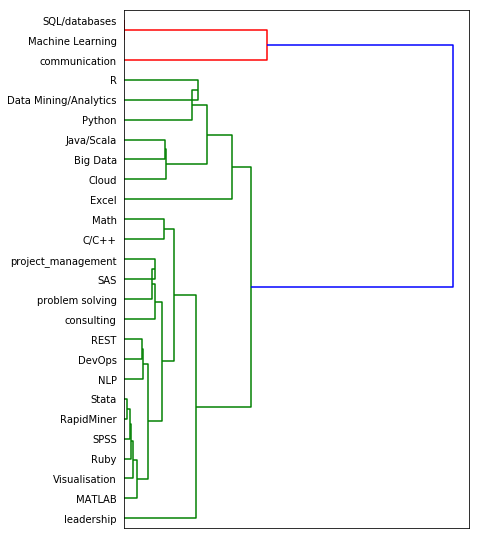

In [48]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])


Z1 = sch.dendrogram(Y, orientation='right')
ax1.set_xticks([])
ax1.set_yticklabels(labels)

plt.plot() # supress prints

## Hierarchical clustering of the scraped Indeed.ca data

### Read the scraped Indeed.ca data

In [58]:
kaggle_survey_path = 'kaggle-survey-2018/multipleChoiceResponses.csv'

question_list = pd.read_csv(kaggle_survey_path, nrows=1)
question_list = question_list.iloc[0]

responses_only = pd.read_csv(kaggle_survey_path, low_memory=False)
responses_only = responses_only.drop(0)

responses_only['Time from Start to Finish (seconds)'] = \
    responses_only['Time from Start to Finish (seconds)'].astype('int')

responses_only['Time from Start to Finish (minutes)'] = \
    responses_only['Time from Start to Finish (seconds)'] // 60

# this would only work if column Q9 contains numerical info, original Kaggle survey has it as categories
#responses_only['Q9'] = pd.to_numeric(responses_only['Q9'], errors='raise')

print("{0:,} rows in the DataFrame.".format(len(responses_only)))
responses_only.head(1)

23,859 rows in the DataFrame.


,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,Time from Start to Finish (minutes)
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,11


### Define functions

`plot_bars_with_minmax`

In [59]:
def plot_bars_with_minmax(series_to_plot, plot_title, horizontal=False, color='gray',
                          fig_height=5, fig_width=8,
                          font_color='darkblue',
                          xlabel="", ylabel="", tick_label_size=16,
                          with_minmax=True, with_mean=True,
                          min_border=0.95, max_border=0.99, minmax_width=0.5,
                          sup_line=None):
    """
    function to plot a gray bar chart from a pandas Series,
    plots mean
    highlights bars with minimum values

    Input arguments: series_to_plot -- pandas Series -- Series to plot as a bar chart
                     title          -- string        -- string containing title of the chart
                     with_minmax    -- boolean       -- option to highlight extreme values
                                                        from the Series (default=True)
                     min_border     -- float         -- height limit for black min bar on the plot
                                                        (default=0.95)
                     max_border     -- float         -- height limit for lightgray max bar on the plot
                                                        (default=0.99)
                     minmax_width   -- float         -- width for min and max bars on the plot
                                                        (default=0.5)


    Output:          None, plots and shows bar chart with mean and extremes (optional) highlighted
    """
    font = dict(family='serif', color=font_color, weight='normal', size=16)

    # create figure and axis
    fig, ax = plt.subplots(1, figsize=(fig_width, fig_height))

    if horizontal:
        # plot a horizontal bar chart from input Series
        plt.barh(y=series_to_plot.index,
                 width=series_to_plot,
                 color=color)
        if with_mean:
            # plot mean of the series
            ax.axvline(series_to_plot.mean(), color='black', linestyle='--', linewidth=1)
            ax.text(series_to_plot.mean() * 1.05,
                    0,
                    "Mean: {0:.2f}".format(series_to_plot.mean()),
                    fontsize=16)
        if sup_line:
            ax.axhline(sup_line, color='black', linestyle='--', linewidth=1)
        # optional: highlight the bars with minimum values (if input parameter 'with_min' is True)
        if with_minmax:
            min_se = series_to_plot[series_to_plot == series_to_plot.min()]
            plt.barh(min_se.index,
                     min_se * min_border,
                     minmax_width,
                     color='black')

            max_se = series_to_plot[series_to_plot == series_to_plot.max()]
            plt.barh(max_se.index,
                     max_se * max_border,
                     minmax_width,
                     color='lightgray')
        # set axis parameters
        ax.set_xlabel(xlabel, fontdict=font)
        ax.set_ylabel(ylabel, fontdict=font)
        ax.tick_params('both', labelrotation=1, labelsize=tick_label_size)

    else:
        # plot a bar chart from input Series
        plt.bar(x=series_to_plot.index,
                height=series_to_plot,
                color=color)

        if with_mean:
            # plot mean of the series
            ax.axhline(series_to_plot.mean(), color='black', linestyle='--', linewidth=1)
            ax.text(0,
                    series_to_plot.mean() * 1.01,
                    "Mean: {0:.2f}".format(series_to_plot.mean()))

        # optional: highlight the bars with minimum values (if input parameter 'with_min' is True)
        if with_minmax:
            min_se = series_to_plot[series_to_plot == series_to_plot.min()]
            plt.bar(x=min_se.index,
                    height=min_se * min_border,
                    color='black',
                    width=minmax_width)
            max_se = series_to_plot[series_to_plot == series_to_plot.max()]
            plt.bar(x=max_se.index,
                    height=max_se * max_border,
                    color='lightgray',
                    width=minmax_width)
        if sup_line:
            ax.axvline(sup_line, color='black', linestyle='--', linewidth=1)
        # set axis parameters
        ax.set_xlabel(xlabel, fontdict=font)
        ax.set_xticks(series_to_plot.index)
        ax.set_ylabel(ylabel, fontdict=font)
        ax.tick_params('both', labelrotation=1, labelsize=tick_label_size)

    # set general axis parameters
    ax.set_title(plot_title, fontdict=font)
    ax.grid(False)

    plt.show()
    return


`plot_q_parts`

In [50]:
def plot_q_parts(question_list, response_df,
                 question, parts,
                 comment='', return_subset=False, tick_label_size=12,
                 fig_height=5, fig_width=8,
                 with_minmax=True):
    """
    a function to plot results of a question from Kaggle survey
    that are stored in a range of columns
    """
    question_start_col = question + '_Part_1'
    question_last_col = question + '_Part_' + str(parts)

    question_subset = response_df.loc[:, question_start_col:question_last_col]
    answer_categories = []
    for column in question_subset.columns:
        answer_categories.append(question_list.loc[column].split(' - ')[-1])

    question_subset.columns = answer_categories

    series_to_plot = question_subset.count().sort_values(ascending=False)

    title = question + ': ' + question_list[question + '_Part_1'].split(' - ')[0] + '\n' + comment

    plot_bars_with_minmax(series_to_plot, title, horizontal=True,
                          with_mean=False,
                          tick_label_size=tick_label_size,
                          fig_height=fig_height, fig_width=fig_width,
                          with_minmax=with_minmax)

    if return_subset:
        return series_to_plot
    else:
        return


### Generate the subset of relevant columns from the Kaggle survey

In [86]:
question_subset[0]

array(['Analyze and understand data to influence product or business decisions',
       'Build and/or run a machine learning service that operationally improves my product or workflows',
       'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data',
       nan,
       'Do research that advances the state of the art of machine learning',
       nan, nan], dtype=object)

In [101]:
array = ['word1', 'word2', 'word3', 'word1']
label_encoder.fit_transform(array)

array([0, 1, 2, 0], dtype=int64)

In [106]:
question_subset['Q11_Part_1'].value_counts()

Analyze and understand data to influence product or business decisions    9532
Name: Q11_Part_1, dtype: int64

In [107]:
question_subset['Q11_Part_2'].value_counts()

Build and/or run a machine learning service that operationally improves my product or workflows    5481
Name: Q11_Part_2, dtype: int64

In [94]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

def encode_col(col):
    return label_encoder.fit_transform(col)

In [93]:
selected_questions_subset = pd.DataFrame()

for question in 
question_subset = responses_only.loc[:, 'Q11_Part_1':'Q11_Part_7'].copy()

,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7
1,Analyze and understand data to influence produ...,Build and/or run a machine learning service th...,Build and/or run the data infrastructure that ...,NaN,Do research that advances the state of the art...,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN
3,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,Other


In [111]:
question = 'Q11'
parts = 7

question_start_col = question + '_Part_1'
question_last_col = question + '_Part_' + str(parts)

question_subset = responses_only.loc[:, question_start_col:question_last_col]
answer_categories = []
for column in question_subset.columns:
    answer_categories.append(question_list.loc[column].split(' - ')[-1])
    question_subset[column] = question_subset[column].str.replace(answer_categories[-1], '1')
    question_subset[column] = question_subset[column].fillna(0)

question_subset.columns = answer_categories
question_subset

,Analyze and understand data to influence product or business decisions,Build and/or run a machine learning service that operationally improves my product or workflows,"Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Build prototypes to explore applying machine learning to new areas,Do research that advances the state of the art of machine learning,None of these activities are an important part of my role at work,Other
1,1,1,1,0,1,0,0
2,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1
6,1,0,0,1,1,0,0
7,0,0,0,0,0,1,0
8,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0
10,0,1,1,0,0,0,0


In [97]:
label_encoder.fit_transform(question_subset.iloc[0])

TypeError: '<' not supported between instances of 'float' and 'str'

Q11: Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions


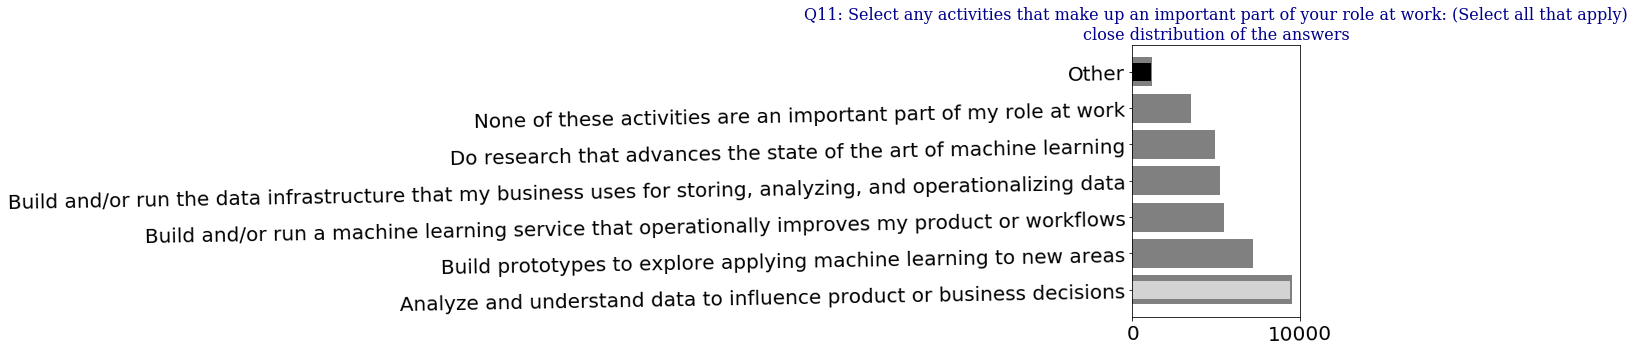

In [70]:
question = 'Q11'
parts = 7
comment = 'close distribution of the answers'

print(question + ': ' + question_list[question + '_Part_1'])

question_subset = plot_q_parts(question_list, responses_only, question, 
                             parts, comment, tick_label_size=20, fig_width=3, return_subset=True)

In [73]:
select_questions = ['Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q19', 'Q21', 'Q31', 'Q47']

In [75]:
for question in select_questions:
    print(question)

Q11
Q12
Q13
Q14
Q15
Q16
Q19
Q21
Q31
Q47


In [ ]:
for quesiton in select_questions    
    question_start_col = question + '_Part_1'
    question_last_col = question + '_Part_' + str(parts)

    question_subset = response_df.loc[:, question_start_col:question_last_col]
    answer_categories = []
    for column in question_subset.columns:
        answer_categories.append(question_list.loc[column].split(' - ')[-1])

    question_subset.columns = answer_categories

    series_to_plot = question_subset.count().sort_values(ascending=False)

    title = question + ': ' + question_list[question + '_Part_1'].split(' - ')[0] + '\n' + comment

    plot_bars_with_minmax(series_to_plot, title, horizontal=True,
                          with_mean=False,
                          tick_label_size=tick_label_size,
                          fig_height=fig_height, fig_width=fig_width,
                          with_minmax=with_minmax)

    if return_subset:
        return series_to_plot
    else:
        return


In [71]:
question_subset

Analyze and understand data to influence product or business decisions                                              9532
Build prototypes to explore applying machine learning to new areas                                                  7233
Build and/or run a machine learning service that operationally improves my product or workflows                     5481
Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data    5233
Do research that advances the state of the art of machine learning                                                  4934
None of these activities are an important part of my role at work                                                   3471
Other                                                                                                               1192
dtype: int64

In [67]:
question_list['Q12_Part_1_TEXT']

'What is the primary tool that you use at work or school to analyze data? (include text response) - Basic statistical software (Microsoft Excel, Google Sheets, etc.) - Text'

In [68]:
responses_only.loc[:, 'Q12_Part_1_TEXT'].value_counts()

-1      19932
1        1237
10        416
2         311
11         92
76         75
41         36
6          35
31         35
16         33
56         27
62         23
144        20
172        20
116        19
3          18
25         15
127        12
245        11
83         10
54         10
82         10
138         9
118         9
140         9
158         9
28          8
467         8
27          8
97          8
        ...  
568         1
293         1
1141        1
493         1
285         1
632         1
774         1
186         1
686         1
883         1
919         1
675         1
292         1
555         1
810         1
854         1
152         1
968         1
1074        1
1032        1
451         1
196         1
875         1
847         1
583         1
246         1
851         1
29          1
165         1
832         1
Name: Q12_Part_1_TEXT, Length: 1210, dtype: int64

In [64]:
question_list.iloc[0:60]

Time from Start to Finish (seconds)                                Duration (in seconds)
Q1                                                What is your gender? - Selected Choice
Q1_OTHER_TEXT                          What is your gender? - Prefer to self-describe...
Q2                                                           What is your age (# years)?
Q3                                             In which country do you currently reside?
Q4                                     What is the highest level of formal education ...
Q5                                     Which best describes your undergraduate major?...
Q6                                     Select the title most similar to your current ...
Q6_OTHER_TEXT                          Select the title most similar to your current ...
Q7                                     In what industry is your current employer/cont...
Q7_OTHER_TEXT                          In what industry is your current employer/cont...
Q8                   

In [60]:
responses_only.head()
selected_questions = [[]
    
]

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT,Time from Start to Finish (minutes)
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,11
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,7
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1,11
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,10
5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1,12


### Get a list with skill names from DF columns

In [42]:
# get the list of skill names
skills_list = df.columns.values
skills_list

array(['Big Data', 'C/C++', 'Cloud', 'Data Mining/Analytics', 'DevOps',
       'Excel', 'Java/Scala', 'MATLAB', 'Machine Learning', 'Math', 'NLP',
       'Python', 'R', 'REST', 'RapidMiner', 'Ruby', 'SAS', 'SPSS',
       'SQL/databases', 'Stata', 'Visualisation', 'communication',
       'consulting', 'leadership', 'problem solving',
       'project_management'], dtype=object)

### Workflow sample -- number of job posts that mention both 'Big data' and 'DevOps'

In [29]:
mask1 = df['Big Data'] == 1
mask2 = df['DevOps'] == 1
len(df[mask1 & mask2])

24

### Generate of matrix of skill co-occurances

Record number of posts where both skills get mentioned for each pair of skills

In [17]:
# empty matrix is fill
num_skills = len(df.columns)
D = sci_zeros([num_skills, num_skills])

# Find all element wise temp differences
for i in range(num_skills):
    for j in range(num_skills):
        mask1 = df.iloc[:, i] == 1
        mask2 = df.iloc[:, j] == 1
        D[i,j] = len(df[mask1 & mask2])

* Recorded matrix of counts per skill pair. 

* Diagonal is skill "paired" with itself, simply represents total number of job posts where that individual skill is mentioned.

In [20]:
D

array([[224.,  49.,  99., 125.,  24.,  59., 121.,   8., 224.,  67.,  28.,
        182., 118.,  12.,   2.,   9.,  30.,   4., 224.,   1.,  13., 120.,
         24.,  32.,  17.,  19.],
       [ 49., 127.,  42.,  44.,  19.,  36.,  78.,  13., 127.,  25.,  16.,
        111.,  56.,   6.,   2.,   3.,   5.,   1., 127.,   0.,   2.,  83.,
          5.,  24.,  14.,   8.],
       [ 99.,  42., 179.,  82.,  28.,  48., 107.,   9., 179.,  33.,  21.,
        141.,  80.,  26.,   2.,  10.,  19.,   2., 179.,   1.,   9., 102.,
         14.,  24.,  22.,  24.],
       [125.,  44.,  82., 318.,  24., 116., 103.,  13., 318.,  72.,  24.,
        180., 148.,  14.,   5.,   2.,  41.,   8., 318.,   1.,  15., 211.,
         39.,  70.,  45.,  27.],
       [ 24.,  19.,  28.,  24.,  61.,  11.,  38.,   2.,  61.,   9.,   5.,
         43.,  19.,  12.,   0.,   5.,   6.,   0.,  61.,   0.,   2.,  33.,
          3.,   9.,   5.,   5.],
       [ 59.,  36.,  48., 116.,  11., 383.,  45.,  11., 383.,  44.,   9.,
        114., 144.,  

### Normalize the generated matrix of skill co-occurances

In [22]:
D_norm = normalize(D)
D_norm

array([[0.43317649, 0.09475736, 0.19144854, 0.24172795, 0.04641177,
        0.11409559, 0.23399266, 0.01547059, 0.43317649, 0.12956618,
        0.05414706, 0.3519559 , 0.22819119, 0.02320588, 0.00386765,
        0.01740441, 0.05801471, 0.00773529, 0.43317649, 0.00193382,
        0.02513971, 0.23205884, 0.04641177, 0.06188236, 0.032875  ,
        0.03674265],
       [0.16654244, 0.4316508 , 0.14275066, 0.14954831, 0.06457768,
        0.12235771, 0.26510837, 0.04418473, 0.4316508 , 0.08497063,
        0.0543812 , 0.3772696 , 0.19033421, 0.02039295, 0.00679765,
        0.01019648, 0.01699413, 0.00339883, 0.4316508 , 0.        ,
        0.00679765, 0.28210249, 0.01699413, 0.08157181, 0.04758355,
        0.0271906 ],
       [0.23989587, 0.10177401, 0.43375112, 0.19870163, 0.06784934,
        0.11631315, 0.25928139, 0.02180872, 0.43375112, 0.07996529,
        0.050887  , 0.34166987, 0.19385525, 0.06300296, 0.00484638,
        0.02423191, 0.04604062, 0.00484638, 0.43375112, 0.00242319,
      

In [23]:
Y = sch.linkage(D, method='centroid')

In [24]:
Y

array([[8.00000000e+00, 1.80000000e+01, 0.00000000e+00, 2.00000000e+00],
       [1.40000000e+01, 1.90000000e+01, 1.39283883e+01, 2.00000000e+00],
       [1.70000000e+01, 2.70000000e+01, 2.31408729e+01, 3.00000000e+00],
       [1.50000000e+01, 2.80000000e+01, 2.64259973e+01, 4.00000000e+00],
       [2.00000000e+01, 2.90000000e+01, 3.66444061e+01, 5.00000000e+00],
       [7.00000000e+00, 3.00000000e+01, 5.23870213e+01, 6.00000000e+00],
       [4.00000000e+00, 1.30000000e+01, 7.14352854e+01, 2.00000000e+00],
       [1.00000000e+01, 3.20000000e+01, 7.31966529e+01, 3.00000000e+00],
       [3.10000000e+01, 3.30000000e+01, 9.10143456e+01, 9.00000000e+00],
       [1.60000000e+01, 2.50000000e+01, 1.18793939e+02, 2.00000000e+00],
       [2.40000000e+01, 3.50000000e+01, 1.08600184e+02, 3.00000000e+00],
       [2.20000000e+01, 3.60000000e+01, 1.19737676e+02, 4.00000000e+00],
       [3.40000000e+01, 3.70000000e+01, 1.45875354e+02, 1.30000000e+01],
       [1.00000000e+00, 9.00000000e+00, 1.53238376e

In [47]:
labels = skills_list[Z1['leaves']]
labels

array(['leadership', 'MATLAB', 'Visualisation', 'Ruby', 'SPSS',
       'RapidMiner', 'Stata', 'NLP', 'DevOps', 'REST', 'consulting',
       'problem solving', 'SAS', 'project_management', 'C/C++', 'Math',
       'Excel', 'Cloud', 'Big Data', 'Java/Scala', 'Python',
       'Data Mining/Analytics', 'R', 'communication', 'Machine Learning',
       'SQL/databases'], dtype=object)

[]

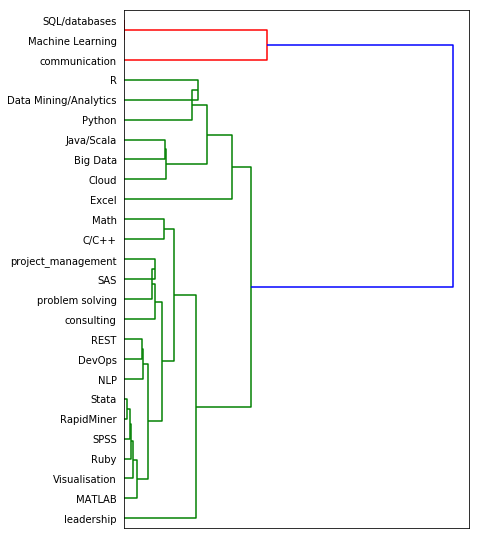

In [48]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])


Z1 = sch.dendrogram(Y, orientation='right')
ax1.set_xticks([])
ax1.set_yticklabels(labels)

plt.plot() # supress prints